In [1]:
# # header
import sys
sys.path.append(r"../")

%load_ext autoreload
%autoreload 2

In [2]:
# # built-in modules
import os
# # Torch modules
import torch
from torchvision import transforms, datasets
# # other modules
import matplotlib.pyplot as plt
# # internal imports
from prelude import load_dicts, startup_folders, get_device
from src.composer import Broken_CIFAR, Search_CIFAR, Cued_CIFAR
from src.model import AttentionModel
from src.utils import plot_all
from src.utils import build_loaders
from src.conductor import AttentionTrain

In [3]:
def calc_Pearson_correlation(a, b):
    a_ = a.view(a.size(0), -1)
    b_ = b.view(b.size(0), -1)
    a_ = a_ - a_.mean(dim=1, keepdim=True)
    b_ = b_ - b_.mean(dim=1, keepdim=True)
    an_ = torch.norm(a_, dim=1, keepdim=True)
    bn_ = torch.norm(b_, dim=1, keepdim=True)
    return torch.mm(a_, b_.t()) / (an_ * bn_.t())

def calc_cosine_similarity(a, b):
    a_ = a.view(a.size(0), -1)
    b_ = b.view(b.size(0), -1)
    an_ = torch.norm(a_, dim=1, keepdim=True)
    bn_ = torch.norm(b_, dim=1, keepdim=True)
    return torch.mm(a_, b_.t()) / (an_ * bn_.t())

In [4]:
start_folder = r"../pretrained/stl10"
results_folder, logger = startup_folders(start_folder, name=f"exp_coco")
data_path = r"../data"

../pretrained/stl10/1753611573 was created!


In [5]:
model_params = load_dicts(start_folder, "model_params")
tasks = load_dicts(start_folder, "tasks")
train_params = load_dicts(start_folder, "train_params")
DeVice, num_workers, pin_memory = get_device()
print(f"model_params: {model_params}")
print(f"tasks: {tasks}")
print(f"train_params: {train_params}")

Device set to mps
model_params: {'in_dims': [3, 192, 192], 'n_classes': 10, 'out_dim': 10, 'normalize': True, 'softness': 0.5, 'channels': [3, 32, 32, 64, 64, 128, 128], 'residuals': False, 'kernels': 3, 'strides': 1, 'paddings': 1, 'conv_bias': True, 'conv_norms': [None, 'layer', 'layer', 'layer', 'layer', 'layer'], 'conv_dropouts': 0.0, 'conv_funs': GELU(approximate='none'), 'deconv_funs': Tanh(), 'deconv_norms': [None, 'layer', 'layer', 'layer', 'layer', 'layer'], 'pools': [2, 2, 2, 2, 2, 2], 'rnn_dims': [64], 'rnn_bias': True, 'rnn_dropouts': 0.0, 'rnn_funs': GELU(approximate='none'), 'n_tasks': 3, 'task_layers': 1, 'task_weight': True, 'task_bias': True, 'task_funs': Tanh(), 'rnn_to_fc': True, 'trans_fun': Identity()}
tasks: {'Recognition': {'composer': 'Broken_CIFAR', 'key': 0, 'params': {'in_dims': [3, 64, 64], 'out_dims': [3, 192, 192], 'n_iter': 1, 'gap': 8, 'noise': 0.25, 'hard': False}, 'datasets': ['Broken_CIFAR', 'Broken_CIFAR', 'Broken_CIFAR'], 'dataloaders': [None, None,

In [6]:
for o in tasks:
    tasks[o]["composer"] = Broken_CIFAR if o == "Recognition" else Cued_CIFAR if o == "Cued_Recognition" else Search_CIFAR
    tasks[o]["datasets"] = []
    tasks[o]["dataloaders"] = []
    tasks[o]["loss_s"] = ((-1, ), (-1, ))


In [9]:
# datasets and dataloaders
pre_trans = transforms.Compose([
    transforms.Resize(64, interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
    transforms.ToTensor()
])
train_ds = datasets.STL10(root=data_path, split="train", download=False, transform=pre_trans)
stl_eval_test = datasets.STL10(root=data_path, split="test", download=False, transform=pre_trans)
valid_ds = torch.utils.data.Subset(stl_eval_test, range(4000))
test_ds = torch.utils.data.Subset(stl_eval_test, range(4000, 8000))
DeVice, num_workers, pin_memory = get_device()
for o in tasks:
    tasks[o]["datasets"].append(tasks[o]["composer"](train_ds, **tasks[o]["params"]))
    tasks[o]["datasets"].append(tasks[o]["composer"](valid_ds, **tasks[o]["params"]))
    tasks[o]["datasets"].append(tasks[o]["composer"](test_ds, **tasks[o]["params"]))
    tasks[o]["datasets"][1].build_valid_test()
    tasks[o]["datasets"][2].build_valid_test()
    tasks[o]["dataloaders"] = build_loaders(tasks[o]["datasets"], batch_size=train_params["batch_size"], num_workers=num_workers, pin_memory=pin_memory)


Device set to mps


In [10]:
# model and conductor...
model = AttentionModel(**model_params)
conductor = AttentionTrain(model, None, None, tasks, logger, results_folder)
model_dir = os.path.join(start_folder, "model" + ".pth")
assert os.path.exists(model_dir), "Could not find the model.pth in the given dir!"
model.load_state_dict(torch.load(model_dir, map_location=DeVice))

<All keys matched successfully>

In [11]:
# training...
plot_all(10, model, tasks, results_folder, "_test", DeVice, logger, False, kind="test")
conductor.eval(DeVice,  "test")

testing...
  Task Recognition:
    CEi Loss: 2.621    CEe Loss: 0.919    Pix Err: 0.000    Att Acc: 0.000    Cls Acc: 2783/4000
  Task Cued_Recognition:
    CEi Loss: 0.855    CEe Loss: 0.851    Pix Err: 0.007    Att Acc: 0.945    Cls Acc: 2979/4000
  Task Search:
    CEi Loss: 0.702    CEe Loss: 0.717    Pix Err: 0.033    Att Acc: 0.857    Cls Acc: 2978/4000


In [12]:
train_ds.classes == ['airplane','bird','car','cat','deer','dog','horse','monkey', 'ship', 'truck']
class_names = ['airplane', 'ship', 'car', 'truck', 'bird', 'cat', 'dog', 'deer', 'horse', 'monkey']
class_idxes = (0, 8, 2, 9, 1, 3, 5, 4, 6, 7)
list((train_ds.classes[i] for i in class_idxes)) == class_names

True

In [14]:
layer_ = -1
# n_samples = len(tasks["Recognition"]["datasets"][2])
n_samples = 32
n_class = 10
n_class_sample = [0 for _ in range(n_class)]
feature_dim = model.conv_dims[layer_]
model.to(DeVice)
model.eval()
ds_task_image_rep_pre = torch.zeros(3, n_class, n_samples, *feature_dim)
ds_task_image_rep_post = torch.zeros(3, n_class, n_samples, *feature_dim)
for j in range(n_class * n_samples * 2):
    for i, k in enumerate(tasks.keys()):
        x, y, _, _, h = tasks[k]["datasets"][2][j]
        if i == 0:
            c = y[-1].item()
            if n_class_sample[c] == n_samples:
                break
            else:
                n_class_sample[c] += 1
                n = n_class_sample[c] - 1
        x, y = x.to(DeVice).unsqueeze(0), y.to(DeVice)
        h = h.to(DeVice).unsqueeze(0) if i == 2 else None
        with torch.no_grad():
            model.initiate_forward(1)
            labels_pre, act_pre = model.for_forward(x[:, -1])
            ds_task_image_rep_pre[i, c, n] = act_pre[layer_-1].detach()
            key = tasks[k]["key"]
            model.initiate_forward(1)
            masks_post, labels_post, act_post = model.forward(x, key, h)
            labels_post_, act_post_ = model.for_forward(x[:, -1])
            ds_task_image_rep_post[i, c, n] = act_post_[layer_-1].detach()
    if sum(n_class_sample) == n_class * n_samples:
        break

In [15]:
ds_task_image_rep_pre = ds_task_image_rep_pre[:, class_idxes]
ds_task_image_rep_post = ds_task_image_rep_post[:, class_idxes]
ds_task_image_rep_pre_f = ds_task_image_rep_pre.reshape(3, n_class * n_samples, -1)
ds_task_image_rep_post_f = ds_task_image_rep_post.reshape(3, n_class * n_samples, -1)

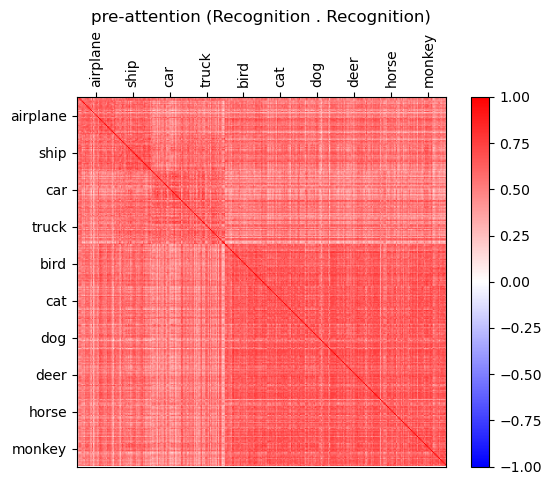

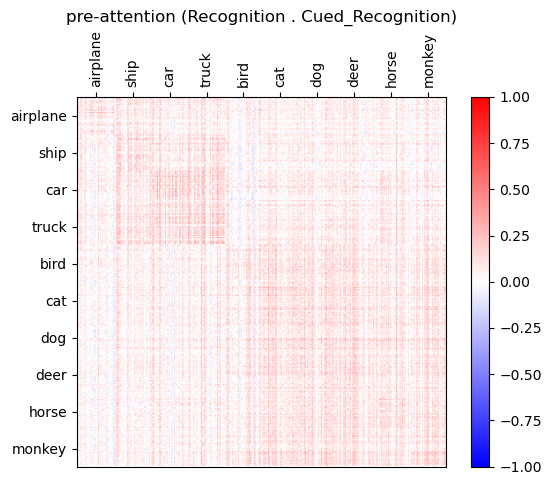

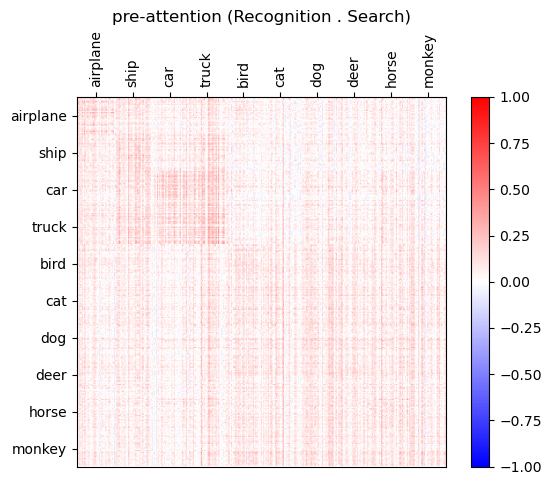

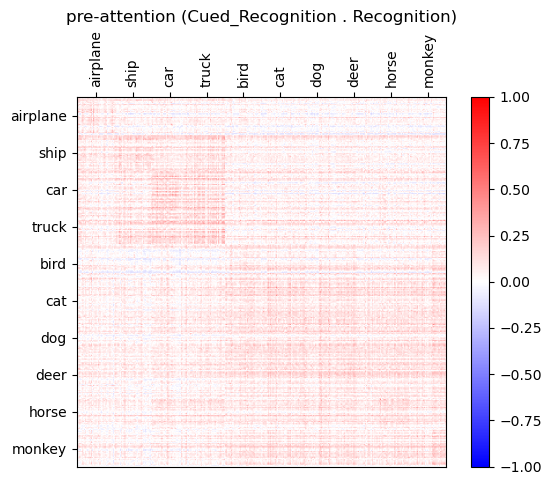

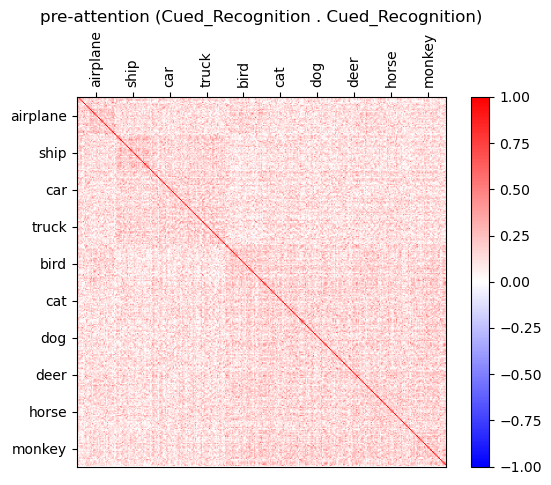

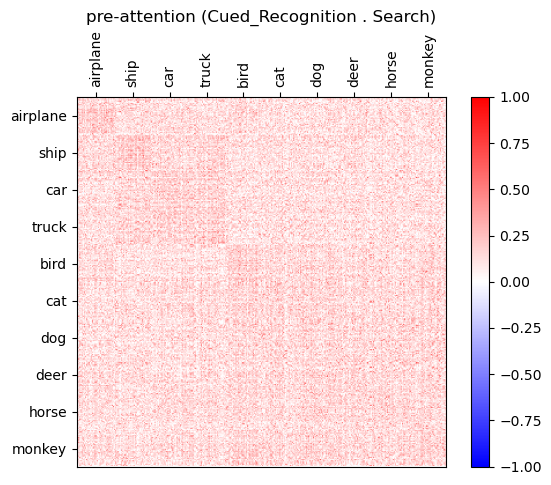

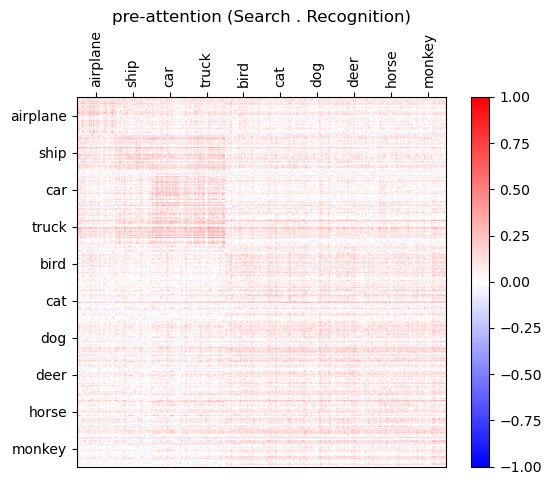

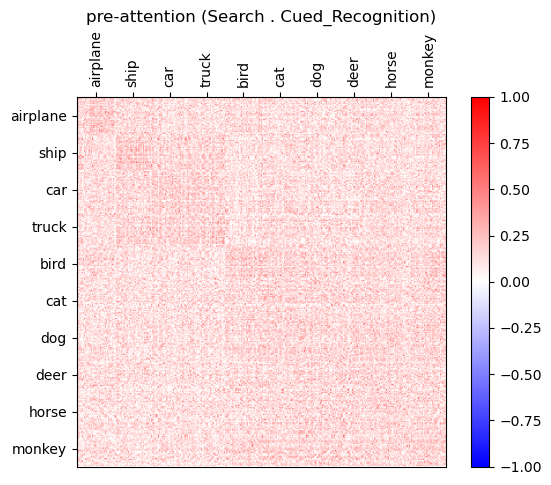

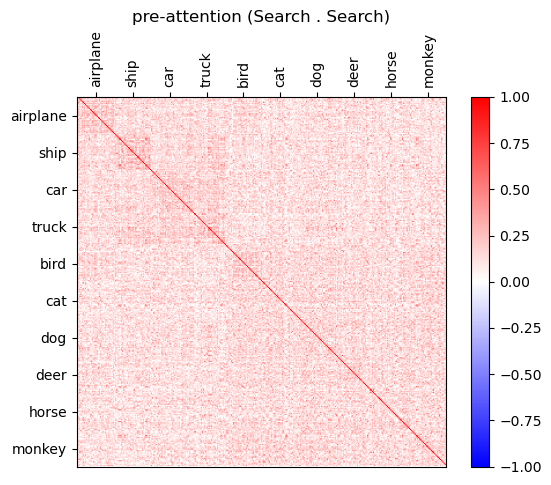

In [18]:
prefix = "pre-attention"
for i, t_i in enumerate(tasks.keys()):
    for j, t_j in enumerate(tasks.keys()):
        aa = calc_Pearson_correlation(ds_task_image_rep_pre_f[i], ds_task_image_rep_pre_f[j])
        # print(aa.min(), aa.max(), aa.mean())
        plt.figure()
        plt.imshow(aa, cmap="bwr", vmin=-1, vmax=1)
        ax = plt.gca()
        ax.xaxis.tick_top()
        plt.xticks(range(n_samples//2, n_class * n_samples + n_samples//2, n_samples), class_names, rotation=90, )
        plt.yticks(range(n_samples//2, n_class * n_samples + n_samples//2, n_samples), class_names)
        plt.colorbar()
        plt.title(f"{prefix} ({t_i} . {t_j})")
        plt.savefig(os.path.join(results_folder, f"RSA_pre_{i}_{j}.svg"), format="svg")
        plt.show()

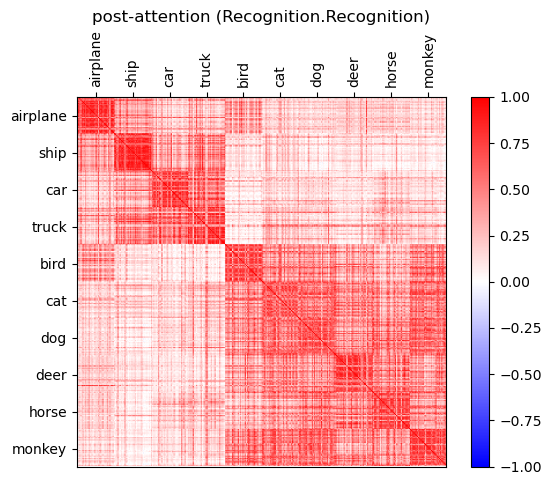

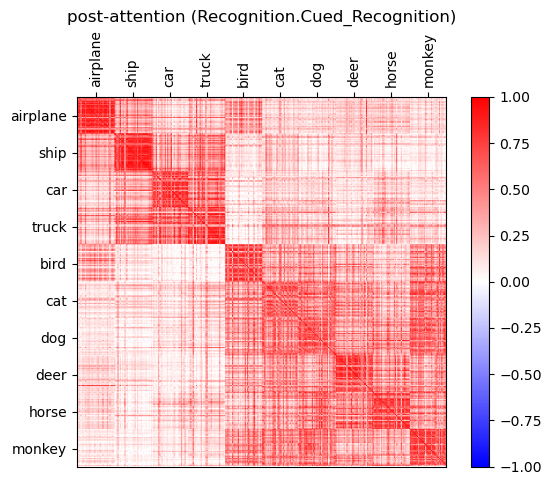

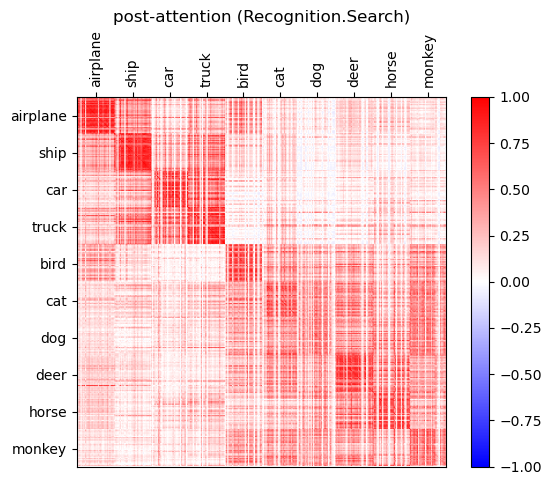

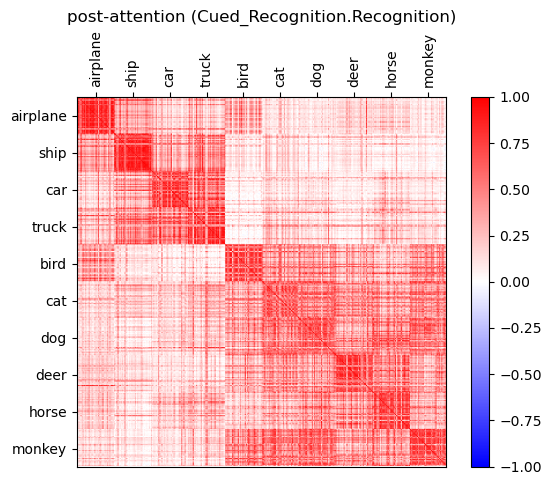

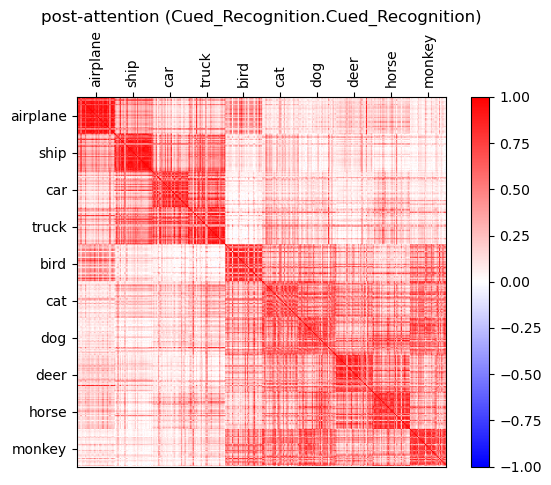

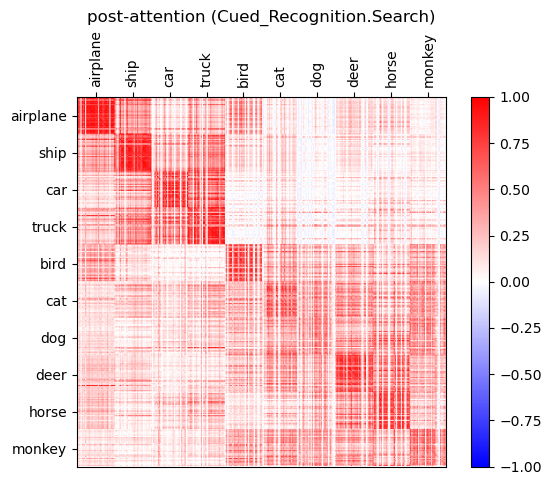

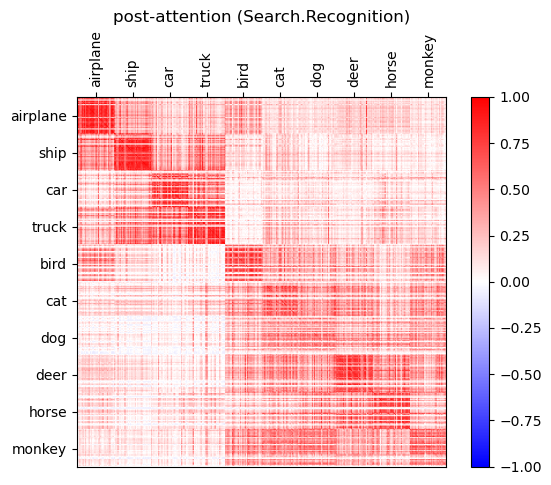

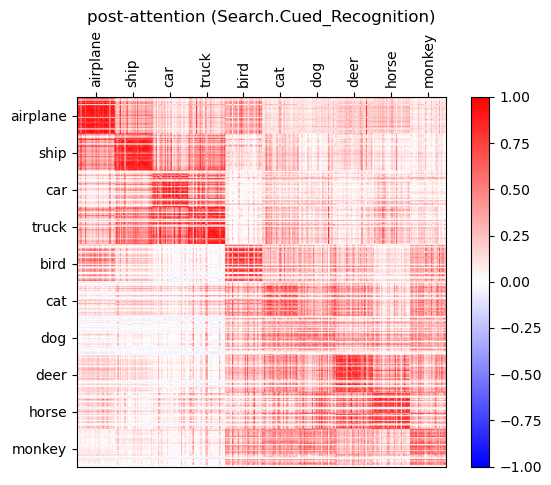

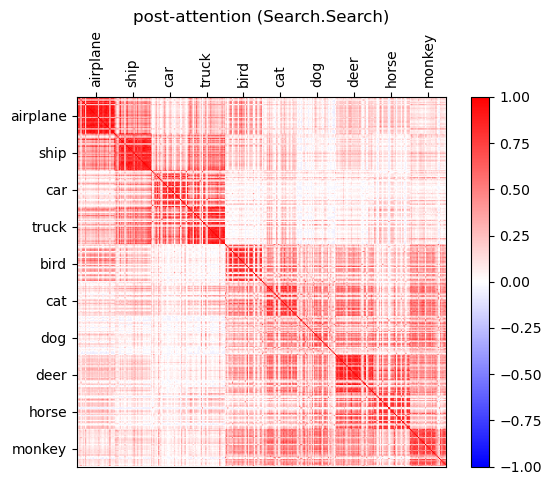

In [19]:
prefix = "post-attention"
for i, t_i in enumerate(tasks.keys()):
    for j, t_j in enumerate(tasks.keys()):
        plt.figure()
        aa = calc_Pearson_correlation(ds_task_image_rep_post_f[i], ds_task_image_rep_post_f[j])
        # print(aa.min(), aa.max(), aa.mean())
        plt.imshow(aa, cmap="bwr", vmin=-1, vmax=1)
        ax = plt.gca()
        ax.xaxis.tick_top()
        plt.xticks(range(n_samples//2, n_class * n_samples + n_samples//2, n_samples), class_names, rotation=90, )
        plt.yticks(range(n_samples//2, n_class * n_samples + n_samples//2, n_samples), class_names)
        plt.colorbar()
        plt.title(f"{prefix} ({t_i}.{t_j})")
        plt.savefig(os.path.join(results_folder, f"RSA_post_{i}_{j}.svg"), format="svg")
        plt.show()